In [1]:
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
import tensorflow_datasets as tfds

### 
https://www.oreilly.com/library/view/ai-and-machine/9781492078180/ch04.html

In [2]:
#the first method
(train_dataset, test_dataset), dataset_info = tfds.load('mnist',
                                                        split=["train","test"],
                                                        with_info=True,
                                                        shuffle_files=True)

tf.Tensor(4, shape=(), dtype=int64)


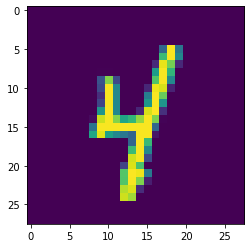

In [3]:
for sample in train_dataset.take(1): #as the take number increases (from 2 to 5), the last bbox related to the last images are shown. 
    image = sample["image"]
    label = sample["label"]
    print(label)
    plt.imshow(image)

In [4]:
#second method
#/home/abaygi/tensorflow_datasets/mnist/3.0.1
(train_dataset, test_dataset), dataset_info = tfds.load("mnist", 
                                                        split=["train", "test"], 
                                                        with_info=True, 
                                                        shuffle_files=True, 
                                                        batch_size=-1, 
                                                        as_supervised=True)

#(training_images, training_labels), (test_images, test_labels)

In [5]:
training_images, training_labels = tfds.as_numpy(train_dataset)

In [6]:
test_images, test_labels = tfds.as_numpy(test_dataset)

In [7]:
#ds = tfds.load('mnist', split='train', shuffle_files=True)

In [8]:
#dataset_info

In [9]:
train_dataset

(<tf.Tensor: shape=(60000, 28, 28, 1), dtype=uint8, numpy=
 array([[[[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         ...,
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]]],
 
 
        [[[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...,
          [0],
          [0],
          [0]],
 
         [[0],
          [0],
          [0],
          ...

In [10]:
#Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [11]:
training_images.shape

(60000, 28, 28, 1)

In [12]:
test_images.shape

(10000, 28, 28, 1)

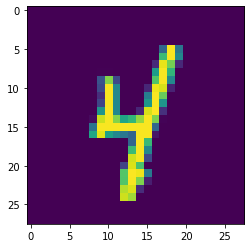

In [13]:
plt.imshow(training_images[0])

### 
In order to use the pre-trained model introduced later in the tutorial, we will need to convert each image into a size of at least (75, 75, 3). Due to the limited RAM, we will use the minimum size. Note that we also have to include three channels instead of just 1 (just copy the same channel 3 times) to make use of the pre-trained weights.

https://www.kaggle.com/saumandas/intro-to-transfer-learning-with-mnist

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((75, 75)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float64)


In [15]:
training_images_75 = [change_size(img) for img in training_images[:10000]]


In [16]:
training_images_75 = np.array(training_images_75)

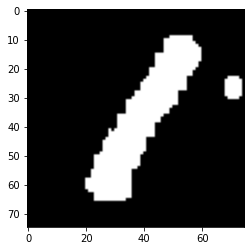

In [17]:
plt.imshow(training_images_75[8])

### Data Augmentation

Data augmentation is one of the most fundamental and useful strategy when dealing with images. It becomes especially useful if we have few images. This is not the case with this dataset, but it will still help anyway. Fortunately, ImageDataGenerator from keras makes it extremely simple to apply these augmentations. However, it is important to be careful when deciding which augmentations to apply.

https://www.kaggle.com/saumandas/intro-to-transfer-learning-with-mnist



In [18]:
image_gen = ImageDataGenerator(rescale=1./255, #easier for network to interpret numbers in range [0,1]
                              zoom_range=0.1,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              validation_split=0.2) # 80/20 train/val split


In [19]:
#dealing with labels

In [20]:
training_labels[0]

4

In [21]:
y = tf.keras.utils.to_categorical(training_labels[:10000]) # one-hot encoding

In [22]:
y[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [23]:
training_images_75.shape

(10000, 75, 75, 3)

In [24]:
train_generator = image_gen.flow(training_images_75, 
                                 y,
                                batch_size=32,
                                shuffle=True,
                                subset='training',
                                seed=42)
valid_generator = image_gen.flow(training_images_75,
                                 y,
                                batch_size=16,
                                shuffle=True,
                                subset='validation')

### Transfer Learning

Many features in general images are common and it is not worth starting to train from scratch. Usually the beginning layers in convolutional neural networks identify extremely basic features such as vertical and horizontal lines. This is what forms the backbone of tranfer learning. Using other peoples models, which have been trained on lots of data and are capable of identifying simple features, to fit your own data.

Imagenet

Imagenet is one of the largest image databases in the world! Every year, they host a competition known as the Imagenet Large Scale Visual Recognition Challenge (ILSVRC), where scientists from all over the world compete to create the best model. A couple years back, a group of researchers came up with the ResNet50, and now it's available to everyone! Learn more about the model here: resnet50 info.

### shape_size for ResNet50
In practice, it is best to use this model with image size (224, 224, 3) since the original model was trained with that size. However, for the purpose of this tutorial (75, 75, 3) will also work. Note that we specified the weights as 'imagenet'. This will automatically load those pretrained weights into the model. If we do not specify, the weights will be initialized randomly and we would be starting from scratch

In [29]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [50]:
# Create base model
base_model = ResNet50(input_shape=(75, 75, 3), 
                 include_top = False, 
                 weights = "imagenet")
# Freeze base model
base_model.trainable = False

In [51]:
# Create new model on top.
inputs = keras.Input(shape=(75, 75, 3))

In [52]:
x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

In [53]:
model = keras.Model(inputs, outputs)

In [54]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 75, 75, 3)]       0         
_________________________________________________________________
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 25,948,426
Trainable params: 2,360,714
Non-trainable params: 23,587,712
_________________________________________________________________


In [57]:
history = model.fit(train_generator,
                   validation_data=valid_generator, 
                   epochs=3)

Epoch 1/3
250/250 [==============================] - 267s 1s/step - loss: 1.2564 - accuracy: 0.6467 - val_loss: 1.1217 - val_accuracy: 0.6835
Epoch 2/3
250/250 [==============================] - 264s 1s/step - loss: 1.0260 - accuracy: 0.7166 - val_loss: 0.9384 - val_accuracy: 0.7290
Epoch 3/3
250/250 [==============================] - 261s 1s/step - loss: 0.8991 - accuracy: 0.7504 - val_loss: 0.8242 - val_accuracy: 0.7665
